In [2]:
!pip install --upgrade pip
!pip install  matplotlib scipy numpy pandas scikit-learn
!pip install "summa==1.2.0" "evaluate==0.4.0" "rouge_score==0.1.2" "sentencepiece"
!pip install cmake
!pip install pyarrow
!pip install rouge
!pip install watermark


In [3]:
!pip install cmake
!pip install pyarrow
!pip install rouge
!pip install sentencepiece


In [4]:
from utils import *
from textrank import *

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:

import pandas as pd
import numpy as np
from functools import partial

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import networkx as nx

from summa import summarizer
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, set_seed
from transformers import LEDForConditionalGeneration, LEDTokenizer
from transformers import BartConfig, BartForConditionalGeneration
from transformers import LEDConfig, LEDForConditionalGeneration
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer
import torch
from datasets import load_dataset

from multiprocessing import Pool
import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

from textwrap import TextWrapper

set_seed(42)

In [6]:
%load_ext watermark
%watermark -a "E. Kiprop" -gu "ernestkiprop" -u -d -v -m

Author: E. Kiprop

Github username: ernestkiprop

Last updated: 2025-03-13

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.27.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1020-nvidia
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



In [7]:
#check how much RAM we have
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi       2.4Gi        19Gi       1.0Mi       9.4Gi        28Gi
Swap:             0B          0B          0B


In [8]:
!nvidia-smi

Thu Mar 13 10:49:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   31C    P8             23W /  230W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Text Rank Algorithms


In [9]:
# We use the first paragraph for the original Transformer paper
# "Attention Is All You Need"
text = "Recurrent neural networks, long short-term memory [13] and gated recurrent [7] \
neural networks in particular, have been firmly established as state of the art approaches \
in sequence modeling and transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous \
efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24, 15]. \
Recurrent models typically factor computation along the symbol positions of the input and output \
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden \
states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently \
sequential nature precludes parallelization within training examples, which becomes critical at longer \
sequence lengths, as memory constraints limit batching across examples. Recent work has achieved \
significant improvements in computational efficiency through factorization tricks [21] and conditional \
computation [32], while also improving model performance in case of the latter. The fundamental \
constraint of sequential computation, however, remains. \
Attention mechanisms have become an integral part of compelling sequence modeling and transduction models \
in various tasks, allowing modeling of dependencies without regard to their distance in \
the input or output sequences [2, 19]. In all but a few cases [27], however, such attention mechanisms \
are used in conjunction with a recurrent network. \
In this work we propose the Transformer, a model architecture eschewing recurrence and instead \
relying entirely on an attention mechanism to draw global dependencies between input and output. \
The Transformer allows for significantly more parallelization and can reach a new state of the art in \
translation quality after being trained for as little as twelve hours on eight P100 GPUs."

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


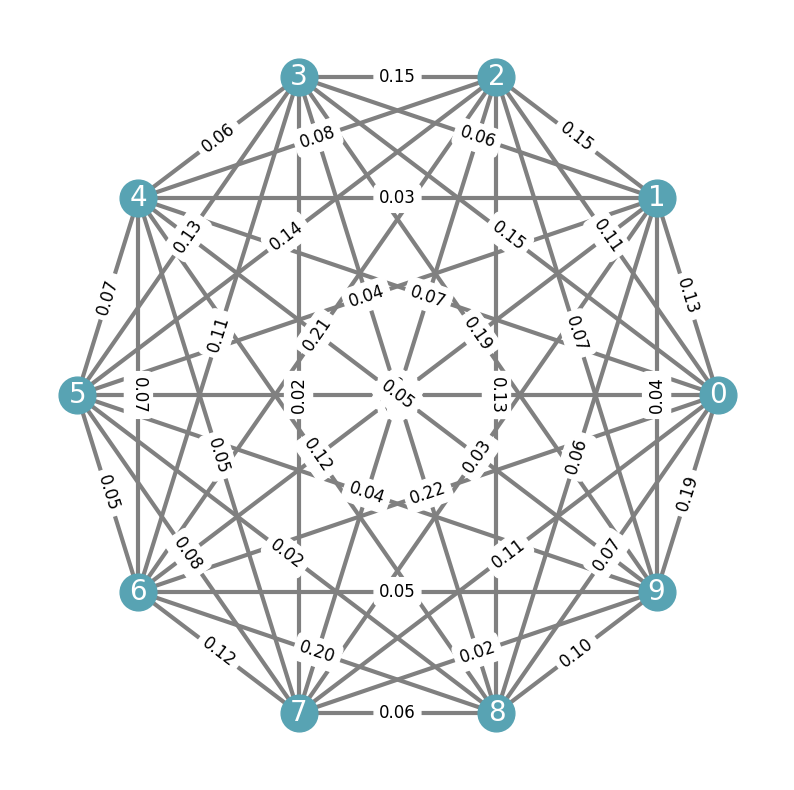

In [10]:
import nltk

nltk.download('punkt_tab')
tr = TextRank()
sentences = tr.split_sentences(text)
G = tr.create_graph(sentences)
tr.plot_graph(G)

Sentence Weights:
Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 3: Unsupervised learning is anothe machine learning technique.
Weight: 0.2469

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 2: Supervised learning is a popular machine learning technique.
Weight: 0.2469

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 1: Deep learning is a technique used in machine learning.
Weight: 0.2210

Sentence 0: Machine learning is a subfield of artificial intelligence.
Sentence 0: Machine learning is a subfield of artificial intelligence.
Weight: 1.0000

Sentence 1: Deep learning is a technique used in machine learning.
Sentence 3: Unsupervised learning is anothe machine learning technique.
Weight: 0.4522

Sentence 1: Deep learning is a technique used in machine learning.
Sentence 2: Supervised learning is a popular machine learning technique.
Weight: 0.4522

Sentence 1: Deep learning is a technique

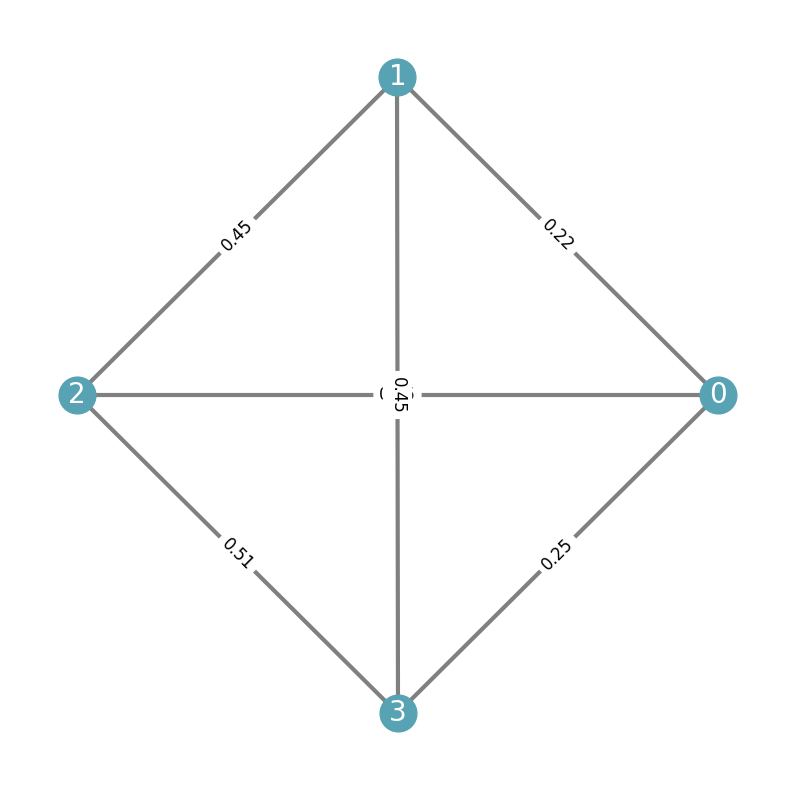

In [11]:
text = """
Machine learning is a subfield of artificial intelligence.
Deep learning is a technique used in machine learning. 
Supervised learning is a popular machine learning technique.
Unsupervised learning is anothe machine learning technique.
"""
tr  = TextRank()
sentences = tr.split_sentences(text)
G = tr.create_graph(sentences)
tr.print_sentence_weights(G, sentences)
tr.plot_graph(G)

### The CNN/Daily Mail dataset


In [12]:
# Loading the CNN/Daily Mail dataset from hugging face datasets
dataset = load_dataset("cnn_dailymail", '3.0.0')

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [14]:
dataset_train = load_dataset('cnn_dailymail', '3.0.0', split='train')
dataset_train.set_format(type='pandas', columns=['article', 'highlights'])

In [15]:
df =dataset_train.to_pandas()
# Use iloc to return the first row of the dataframe
sample=df.iloc[0]


In [16]:
excerpt = 1000
print(f"\033[1mExcerpt of {excerpt} characters, total length of article:\
{len(sample['article'])}:\033[0m\n")

print(sample["article"][:excerpt])
print(f"\033[1m\n\nSummary (length: {len(sample['highlights'])}):\033[0m\n")
print(sample["highlights"])

Excerpt of 1000 characters, total length of article:2527:

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains
access to a reported £20 million ($41.1 million) fortune as he turns
18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the
Phoenix" To the disappointment of gossip columnists around the world,
the young actor says he has no plans to fritter his cash away on fast
cars, drink and celebrity parties. "I don't plan to be one of those
people who, as soon as they turn 18, suddenly buy themselves a massive
sports car collection or something similar," he told an Australian
interviewer earlier this month. "I don't think I'll be particularly
extravagant. "The things I like buying are things that cost about 10
pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to
gamble in a casino, buy a drink in a pub or see the horror film
"Hostel: Part II," currently six places below his 

In [17]:
articles_np = np.array(dataset_train['article'])
articles_np

array(['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. De

In [18]:
articles_np_1 = articles_np[:1]
articles_np_1.shape
articles_np_1

array(['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. De

In [19]:
## Summarizing with TextRank
#Define the function to summarize the text
def summarize_text(text, words=80):
    summary = summarizer.summarize(text, words=words)
    return summary

# Parallelize the TextRank summarization
with  Pool() as pool:
    summarized_articles  = pool.map(summarize_text, articles_np_1)

In [20]:
summarized_articles

['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him.\nDaniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.']

In [22]:
references = np.array(dataset_train['highlights'])
references_np = np.array(references)
references_np[:1]

array(["Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund ."],
      dtype=object)

In [24]:
reference=references[0]
reference

"Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund ."

In [29]:
print(summarized_articles)

['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe
gains access to a reported £20 million ($41.1 million) fortune as he
turns 18 on Monday, but he insists the money won\'t cast a spell on
him.\nDaniel Radcliffe as Harry Potter in "Harry Potter and the Order
of the Phoenix" To the disappointment of gossip columnists around the
world, the young actor says he has no plans to fritter his cash away
on fast cars, drink and celebrity parties.']


In [31]:
summaries={}
summaries['TextRank (Baseline)'] = summarized_articles
print(summaries['TextRank (Baseline)'][0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains
access to a reported £20 million ($41.1 million) fortune as he turns
18 on Monday, but he insists the money won't cast a spell on him.
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the
Phoenix" To the disappointment of gossip columnists around the world,
the young actor says he has no plans to fritter his cash away on fast
cars, drink and celebrity parties.
